In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split , GridSearchCV ,StratifiedKFold , cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , precision_recall_curve , roc_auc_score , roc_curve , classification_report
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier ,plot_tree
from sklearn.ensemble import VotingClassifier ,RandomForestClassifier ,AdaBoostClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier ,RandomForestClassifier ,AdaBoostClassifier ,GradientBoostingClassifier
import tensorflow_decision_forests as tfdf
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-solution-file/solution.csv


# Overview
This project is divided into 2 parts: manual data processing, extraction and TFDF. In the first part, I process, clean and normalize the data, then train it on RandomForest and GradientBoosting,linear model(LG,LassoCV), dence NN, if the models is overfitting after training, I tune them. The second part is data preparation and training models using TFDF from Tensoflow.

**UPD (what I did for impoving):**
* this version score:0.14 with TFDF or 0.15 using NN(normalized all X_train and X_test)
* version 8 score:0.44 - normalization only numerical data, delete NaN-columns with 2.5% of NaNs, using le.encoder for encoding 
* older:0.65 - normalization only numerical data, delete NaN-columns only with 50% of NaNs, using le.encoder for encoding

# Data loading

In [5]:
data=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")


# Data observation

In [6]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [8]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Manually data preprocessing 

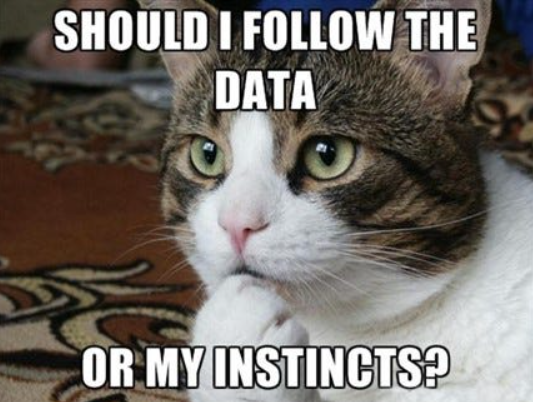

**Finding NaN values**

Dataset contains 1460 rows, which means that *Non-Null Count* column must contains only 1460 values, if all columns do not contains NaN values, as we can see, some columns contain 2% of NaN values and some contain 90+%.

*But if dataset was so perfect, it won't be so intresting, right?*


In [9]:
#check nan with sum()
print("Count the NaN under an entire DataFrame",data.isna().sum().sum())
#check nan with matmul()
nan=data.isna().sum()
print("Count the NaN under an entire DataFrame",nan@(nan.values>0))

Count the NaN under an entire DataFrame 6965
Count the NaN under an entire DataFrame 6965


In [10]:
#create 2 list for sum of nan values of each column and names of this columns
def create_nan_df(data):
    nan_count=[]
    columns_name=[]
    j=0
    for i in list(data.columns):
        nan_values=data[i].isna().sum()
        if nan_values!=0:
            columns_name.append(i)
            nan_count.append(nan_values)
        j+=1
    #create dataframe from 2 lists - columns_name and nan_count, created before
    nan_p= [(x/1460)*100 for x in nan_count] #creates list with % of nan in each column
    nan_df= pd.DataFrame(
        {'columns_name': columns_name,
         'nan_count': nan_count,
         '% of NaN':nan_p
        })
    return nan_df
    

In [11]:
#create dataframe from 2 lists - columns_name and nan_count, created before
nan_df =create_nan_df(data)
nan_df

,columns_name,nan_count,% of NaN
0,LotFrontage,259,17.739726
1,Alley,1369,93.767123
2,MasVnrType,8,0.547945
3,MasVnrArea,8,0.547945
4,BsmtQual,37,2.534247
5,BsmtCond,37,2.534247
6,BsmtExposure,38,2.602740
7,BsmtFinType1,37,2.534247
8,BsmtFinType2,38,2.602740
9,Electrical,1,0.068493


Now we can see what columns contains NaN-value and how much. 

**Two approaches to deal with NaN-values:**
* if the column contains more than X% (for this case X=2.53) NaN-values, this column must be deleted
* else, replace NaN with some values or delete only some rows with NaN. I will use median of each quantitative columns and mode for qualitative.

So, I will delete all columns, that contains NaN more of 2.53% and replace NaN with median in else.


In [ ]:
#find names of columns that contains more than 50% of NaN values
n=nan_df.loc[nan_df['% of NaN']>=2.53]
n.drop(n[n['columns_name'] == 'BsmtFinType1'].index, inplace = True)
list(n["columns_name"])

In [ ]:
#drop this columns from dataset 
data.drop(list(n["columns_name"]),inplace=True, axis = 1)

In [ ]:
#data.drop(['Utilities'],inplace=True, axis = 1)
#this column contain only 1 non-null value

In [ ]:
#data['Utilities'].value_counts()

In [ ]:
data
##81 columns - 15= 66 columns, so deleted successfully

**next, replace all NaN values in another columns whith medians and mode of this columns.**

First, what columns are qualitative and quantitative?

0      LotFrontage - **quantitative**

2       MasVnrType - qualitative

3       MasVnrArea - **quantitative**

4         BsmtQual - qualitative

5         BsmtCond - qualitative

6     BsmtExposure- qualitative

7     BsmtFinType1- qualitative

8     BsmtFinType2- qualitative

9       Electrical- qualitative

10     FireplaceQu- qualitative

11      GarageType- qualitative

12     GarageYrBlt - **quantitative**

13    GarageFinish- qualitative

14      GarageQual- qualitative

15      GarageCond- qualitative

In [ ]:
data.describe()

In [ ]:
#next, replace all NaN values in another columns whith means of this columns
#data["LotFrontage"]=data["LotFrontage"].replace(np.nan, data["LotFrontage"].median())
data["MasVnrType"]=data["MasVnrType"].replace(np.nan, data["MasVnrType"].mode()[0])
data["MasVnrArea"]=data["MasVnrArea"].replace(np.nan, data["MasVnrArea"].median())
#####data["BsmtQual"]=data["BsmtQual"].replace(np.nan, data["BsmtQual"].mode()[0])
#####data["BsmtCond"]=data["BsmtCond"].replace(np.nan, data["BsmtCond"].mode()[0])
#data["BsmtExposure"]=data["BsmtExposure"].replace(np.nan, data["BsmtExposure"].mode()[0])
data["BsmtFinType1"]=data["BsmtFinType1"].replace(np.nan, data["BsmtFinType1"].mode()[0])
#data["BsmtFinType2"]=data["BsmtFinType2"].replace(np.nan, data["BsmtFinType2"].mode()[0])
data["Electrical"]=data["Electrical"].replace(np.nan, data["Electrical"].mode()[0])
#data["FireplaceQu"]=data["FireplaceQu"].replace(np.nan, data["FireplaceQu"].mode()[0])
#data["GarageType"]=data["GarageType"].replace(np.nan, data["GarageType"].mode()[0])
#data["GarageYrBlt"]=data["GarageYrBlt"].replace(np.nan, data["GarageYrBlt"].median())
#data["GarageFinish"]=data["GarageFinish"].replace(np.nan, data["GarageFinish"].mode()[0])
#data["GarageQual"]=data["GarageQual"].replace(np.nan, data["GarageQual"].mode()[0])
#data["GarageCond"]=data["GarageCond"].replace(np.nan, data["GarageCond"].mode()[0])

In [ ]:
#no nan-values
nan_df =create_nan_df(data)
nan_df

In [ ]:

data.isna().sum().sum()

In [ ]:
#what columns contains integer values: it can be or numerical data or already encoded categorical data
df_num = data.select_dtypes(include = ['int64'])
df_num.head()

**Now, we need to convert categorical variables into numerical**

2 MasVnrType - qualitative

4 BsmtQual - qualitative

5 BsmtCond - qualitative

6 BsmtExposure- qualitative

7 BsmtFinType1- qualitative

8 BsmtFinType2- qualitative

9 Electrical- qualitative

10 FireplaceQu- qualitative

11 GarageType- qualitative

13 GarageFinish- qualitative

14 GarageQual- qualitative

15 GarageCond- qualitative

(for doing this in loop can use the describtion file)

In [ ]:
#for already encoded categorical data
def convert_to_categorical(df):
    df['MSSubClass'] = df['MSSubClass'].apply(str)
    df['OverallCond'] = df['OverallCond'].astype(str)
    # df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    
convert_to_categorical(data)

In [ ]:
categories=data.dtypes.loc[data.dtypes=='object'].index
categories

In [ ]:
#categorical_cols = data.select_dtypes(include=np.object).columns


In [22]:
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
le = LabelEncoder()
for i in categories:
    data[i]=le.fit_transform(data[i])
    
data

NameError: name 'categories' is not defined

In [ ]:
#check string type in data
df_num = data.select_dtypes(include = ['object'])
df_num.head()

**Anomaly(outliers) detection and removing**

*Some columns, like MoSold,YrSold,BsmtFullBath,FullBath,HalfBath are categorical data*

In [ ]:
data_without=data.copy()
data_without.drop("Id",inplace=True, axis = 1)

In [ ]:
#data=data_without.copy()

In [ ]:
#data.drop("PoolArea",inplace=True, axis = 1)

In [ ]:
#make array with numerical columns only, which I will clean
data.drop("Id",inplace=True, axis = 1)
features=[
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",#1434 values in this column are 0, so maybe delete
    "GrLivArea",
    "GarageArea",
    "WoodDeckSF",##761 values in this column are 0, so maybe delete
    "OpenPorchSF",
    "EnclosedPorch",#1252 values in this column are 0, so maybe delete
    "3SsnPorch",#1436 values in this column are 0, so maybe delete
    "ScreenPorch",
    "PoolArea",
    "MiscVal"
]
#also create describtion dataframe, coze I need std and mean for anomaly detection
measure=data[features].describe()
measure

In [ ]:
##### outliers detection using standart deviation and mean
import matplotlib.pyplot as plt

u=3
aElevation={}
bElevation={}

X=data.index.tolist()

for col in data[features]:
    aElevation[col]=measure[col][1] - u*measure[col][2]
    bElevation[col]=measure[col][1] + u*measure[col][2]

In [ ]:
#another way to show outliers

#for i, col in enumerate(features):
 #   plt.figure(i,figsize=(2,2))
  #  sns.boxplot(data[col])
   # plt.title(col)

In [ ]:
# define subplot grid
def plot_bounds(aElevation,bElevation,features):
    fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Daily closing prices", fontsize=18, y=0.95)

# loop through tickers and axes
    for f, ax in zip(features, axs.ravel()):
    # filter df for ticker and plot on specified axes
        data[f].plot(ax=ax)
        ax.plot([0,1500],[aElevation[f],aElevation[f]],color='red')
        ax.plot([0,1500],[bElevation[f],bElevation[f]],color='red')

    # chart formatting
        ax.set_title(f.upper())
        #ax.get_legend().remove()
        ax.set_xlabel("")

    plt.show()
    
plot_bounds(aElevation,bElevation,features)


In [ ]:
#remove PoolArea from features that will be cleaning, coze 90% of this column is 0 (home without bath), but its important column for just removing
features_new=features.copy()
#if delete outliers from PoolArea, column becames all-zeros
features_new.remove("PoolArea")
#features_new.remove("LowQualFinSF")
#features_new.remove("3SsnPorch")
#features_new.remove("MiscVal")
features_new

In [ ]:
#all anomaly values replace with median
changed_values=[]
for i in features_new:
    #this step only for count number of outliers
    data[i]=np.where(data[i]>bElevation[i],99999999,data[i])
    data[i]=np.where(data[i]<aElevation[i],99999999,data[i])
    m2=data[i]
    
    changed_values.append(m2[m2==99999999].count())
    #replace
    mediant=data[i].median()
    data[i]=np.where(data[i]==99999999,mediant,data[i])
    data[i]=np.where(data[i]==99999999,mediant,data[i])
    
    

In [ ]:
pd_changed_values=pd.DataFrame(changed_values, columns=['changed'])
pd_changed_values['%']=(pd_changed_values['changed']/1460)*100
pd_changed_values['col']=features_new
pd_changed_values

In [ ]:
#data without anomaly
plot_bounds(aElevation,bElevation,features_new)

**Train/Test Split**

Due to "data leakage" I am scaling X_train and X_test separately

In [ ]:
data

In [ ]:
#take all columns except target (sale price)
columns=data.columns[:64]
columns

In [ ]:

X=data[columns]#data with outliers works more worst
Y=data['SalePrice']#target


In [ ]:
#X=data_without_norm[data_without_norm.columns[:64]]#numerical+categorical feature
#Y=data_without_norm['SalePrice']#target

In [ ]:
#split on train and test data
X_train , X_test ,y_train , y_test = train_test_split(X,Y,test_size = 0.4)
print("X_train shape:",X_train.shape,"X_test shape:",X_test.shape,"y_test shape:",y_test.shape,"y_train shape:",y_train.shape)

In [ ]:
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#creat dataframe from split and test
#X_train_pd=pd.DataFrame(X_train,columns=columns)
#X_test_pd=pd.DataFrame(X_test,columns=columns)
#X_test_pd

In X_train_pd and X_test_pd not only numerical data, which can be scalled, but also categorical, so I will normalize columns, that in fuatures array

In [ ]:
#import sklearn.preprocessing
#def normalize_data(df,features):
    #using MinMaxScaler coze data without anomaly values
    #scaler = sklearn.preprocessing.MinMaxScaler()
    #for i in features:
        #df[i]=scaler.fit_transform(df[i].values.reshape(-1,1))
        
    #return df
#creates numpy array from normalized data
#X_train=normalize_data(X_train_pd,features).to_numpy()
#X_test=normalize_data(X_test_pd,features).to_numpy()

In [ ]:
X_train.shape#the same shape as before

# **RandomForestRandomForestClassifier**

In [ ]:
from sklearn.model_selection import cross_validate, cross_val_score,cross_val_predict
def cross_val(model,x,y):
  cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
  scoring=["r2",'neg_mean_absolute_error']
  cross_val=cross_validate(model,x, y,scoring=scoring,cv=cv,return_train_score=True)
  cv_predicts = cross_val_predict(model,x,y,cv=cv)
  model.fit(x,y)
  cv_predicts=pd.DataFrame(cv_predicts)
  print("Predicted class for each record:",cv_predicts.value_counts(),end='\n')
  
  return model,cross_val

rfc = RandomForestClassifier()
rfc,cv_rfc=cross_val(rfc,X_train, y_train)

In [ ]:
print(cv_rfc['test_r2'])
print(cv_rfc['train_r2'])


In [ ]:

y_pred_test = rfc.predict(X_test)
rmse=mean_squared_error(y_test, y_pred_test,squared=False)
rmse

In [ ]:
#function for tuning
def model_tunning(model,X_train,y_train,param_grid):
     
    grid_search=GridSearchCV(estimator=model,
                param_grid=param_grid,
                scoring='r2',
                verbose=3,
                return_train_score=True)
    grid_search.fit(X_train,y_train)
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print("Best parameters are: ",best_params)
    print('Mean cross-validated recall of the best_estimator is: ',best_score)
    print(best_estimator)
    return best_estimator

In [ ]:
#tunning LogReg model
searchRFC={
    "n_estimators":[400,200,500,1000],
    "criterion":["gini", "entropy", "log_loss"]

}

RFC_tuning=model_tunning(RandomForestClassifier(),X_train,y_train,searchRFC)

In [ ]:
#prediction on model with tuning

y_pred_test = RFC_tuning.predict(X_test)
rmse=mean_squared_error(y_test, y_pred_test,squared=False)
rmse

# **GradientBoostingRegressor**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbc = GradientBoostingRegressor()
gbc,cv_gbc=cross_val(gbc,X_train, y_train)

In [ ]:
cv_gbc

In [ ]:
#higher than RandonForest, but still overfitting
#30842.970316034858 without outliers
y_pred_test = gbc.predict(X_test)
rmse=mean_squared_error(y_test, y_pred_test,squared=False)
rmse


In [ ]:
#tunning model
searchGBC={
    "learning_rate":[0.1,0.01,1,1.5],
    "loss":["huber", "absolute_error", "quantile"],
    "n_estimators":[100,1000,2000,3000],

}

GBC_tuning=model_tunning(GradientBoostingRegressor(),X_train,y_train,searchGBC)

In [ ]:
#small change
y_pred_test = GBC_tuning.predict(X_test)
rmse=mean_squared_error(y_test, y_pred_test,squared=False)
rmse

# Linear Regression

I find, that LG model works best if normalizing only numerical feature, amsemble models are opposite

In [ ]:
from sklearn.linear_model import LinearRegression
lg =  LinearRegression()
lg,cv_lg=cross_val(lg,X_train, y_train)

In [ ]:
cv_lg

In [ ]:
y_pred_test = lg.predict(X_test)
rmse=mean_squared_error(y_test, y_pred_test,squared=False)
rmse
#y_pred_test

# LassoCV

In [ ]:
from sklearn.linear_model import LassoCV
lcv =  LassoCV(max_iter=100000)
lcv,cv_lcv=cross_val(lcv,X_train, y_train)

In [ ]:
#36250.21384143613 on outliers
#34799.32334281733 without outliers
y_pred_test = lcv.predict(X_test)
rmse=mean_squared_error(y_test, y_pred_test,squared=False)
rmse
#r2_score(y_test, y_pred_test)
#y_pred_test

In [ ]:
#tunning model
searchLCV={
    "eps":[0.001,0.0001,0.01],
    "selection":["cyclic", "random"],
    "n_alphas":[100,300,500,1000],

}

LCV_tuning=model_tunning(LassoCV(),X_train,y_train,searchLCV)

In [ ]:
y_pred_test = LCV_tuning.predict(X_test)
rmse=mean_squared_error(y_test, y_pred_test,squared=False)
rmse

# **Neural Network**

Preparing test data as train data before

In [3]:
df=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_test=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")


In [12]:
data_nan=create_nan_df(df)
n=data_nan.loc[data_nan['% of NaN']>=2.53]
#n.drop(n[n['columns_name'] == 'BsmtFinType1'].index, inplace = True)
df.drop(list(n["columns_name"]),inplace=True, axis = 1)
list(n["columns_name"])


['LotFrontage',
 'Alley',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [13]:
data_nant=create_nan_df(df_test)
nan=data_nant.loc[data_nant['% of NaN']>=2.53]
#n.drop(n[n['columns_name'] == 'BsmtFinType1'].index, inplace = True)
df_test.drop(list(nan["columns_name"]),inplace=True, axis = 1)
list(nan["columns_name"])


['LotFrontage',
 'Alley',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [60]:
h=nan["columns_name"].index
list(h)

[1, 2, 8, 9, 10, 11, 13, 21, 22, 23, 24, 27, 28, 29, 30, 31]

In [61]:
data_nant.drop(df.index[list(h)], inplace=True)

AllPub    1459
Name: Utilities, dtype: int64

In [20]:
df_test.isna().sum().sum()

0

In [15]:
df.drop("Id",inplace=True, axis = 1)
df.drop("Utilities",inplace=True, axis = 1)
ids = df_test.pop('Id')
df_test.drop("Utilities",inplace=True, axis = 1)

In [63]:
df_test["PoolArea"].value_counts()

0      1453
144       1
368       1
444       1
228       1
561       1
800       1
Name: PoolArea, dtype: int64

In [18]:
def nan_to_mode(df):
    for col in df.columns:
        mod = df[col].mode()[0]
        df[col] = df[col].fillna(mod)
    return df
df=nan_to_mode(df)
df_test=nan_to_mode(df_test)

In [23]:

def cat_to_num(df):
    categories=df.dtypes.loc[df.dtypes=='object'].index
    for i in categories:
        df[i]=le.fit_transform(df[i])
    return df
df=cat_to_num(df)
df_test=cat_to_num(df_test)

In [ ]:
df

In [25]:
scalert = StandardScaler()
test=scalert.fit_transform(df_test)

In [26]:
X=df[df.columns[:62]]
Y=df["SalePrice"]
X_train , X_test ,y_train , y_test = train_test_split(X,Y,test_size = 0.1)

In [27]:
X_train=X_train.to_numpy()
y_train=y_train.to_numpy()

In [28]:
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

In [29]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]

In [30]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
X_test.shape

(146, 62)

In [32]:
from keras.layers import Dense
#from keras.losses import mean_squared_error
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam



In [154]:
nn = Sequential()
nn.add(Dense(32,input_shape = (X_train.shape[1],), activation = 'relu'))
#nn.add(Dense(256, activation='selu',kernel_regularizer=tf.keras.regularizers.L1(0.01)))
#nn.add(Dropout(0.3))
#nn.add(Dense(256, activation='selu',kernel_regularizer=tf.keras.regularizers.L1(0.01)))
#nn.add(BatchNormalization())
#nn.add(Dense(256, activation='selu'))

#nn.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.03)))
#nn.add(Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.03)))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(64, activation='relu'))

##nn.add(Dropout(0.2))
#nn.add(BatchNormalization())
nn.add(Dense(128, activation='relu'))
nn.add(Dense(256, activation='relu'))
#nn.add(Dropout(0.2))
nn.add(BatchNormalization())
nn.add(Dense(128, activation='relu'))
nn.add(Dense(64, activation='relu'))




#nn.add(Dense(128, activation='selu'))
#nn.add(Dense(128, activation='selu'))
#nn.add(BatchNormalization())
#nn.add(Dense(128, activation='selu'))
nn.add(Dropout(0.2))
nn.add(Dense(1))
#nn.summary()
def rmse(y_real,y_pred):
    rmse=mean_squared_error(y_real, y_pred,squared=False)
    return rmse
callback = EarlyStopping(
    monitor="loss",
    patience=2,
    restore_best_weights=True
)
nn.compile(optimizer=Adam(), loss='mse')


In [155]:
history = nn.fit(X_train,y_train, epochs=150, batch_size=8,validation_data=(X_test,y_test))


Epoch 1/150
148/148 [==============================] - 3s 5ms/step - loss: 34969432064.0000 - val_loss: 29098743808.0000
Epoch 2/150
148/148 [==============================] - 1s 3ms/step - loss: 20612421632.0000 - val_loss: 12413038592.0000
Epoch 3/150
148/148 [==============================] - 1s 3ms/step - loss: 5404764160.0000 - val_loss: 4495003136.0000
Epoch 4/150
148/148 [==============================] - 1s 3ms/step - loss: 4117695488.0000 - val_loss: 4922199040.0000
Epoch 5/150
148/148 [==============================] - 1s 3ms/step - loss: 4463149056.0000 - val_loss: 4096417536.0000
Epoch 6/150
148/148 [==============================] - 1s 3ms/step - loss: 4058907648.0000 - val_loss: 3488340224.0000
Epoch 7/150
148/148 [==============================] - 0s 3ms/step - loss: 3186218240.0000 - val_loss: 2330138624.0000
Epoch 8/150
148/148 [==============================] - 1s 3ms/step - loss: 2961755904.0000 - val_loss: 2314299136.0000
Epoch 9/150
148/148 [=======================

In [156]:

pr_nn=nn.predict(test)


46/46 [==============================] - 0s 2ms/step


In [157]:
pr_nn

array([[128035.66],
       [140030.6 ],
       [206280.25],
       ...,
       [160796.53],
       [120862.66],
       [235461.34]], dtype=float32)

In [38]:
sol=pd.read_csv("/kaggle/input/house-prices-advanced-regression-solution-file/solution.csv")
sol.drop("Id",inplace=True, axis = 1)


In [158]:
rmse=mean_squared_error(sol, pr_nn,squared=False)
rmse

31344.007955696357

In [136]:
print('MSE of the training data: {}' .format(history.history['loss'][-1]))

MSE of the training data: 149046672.0


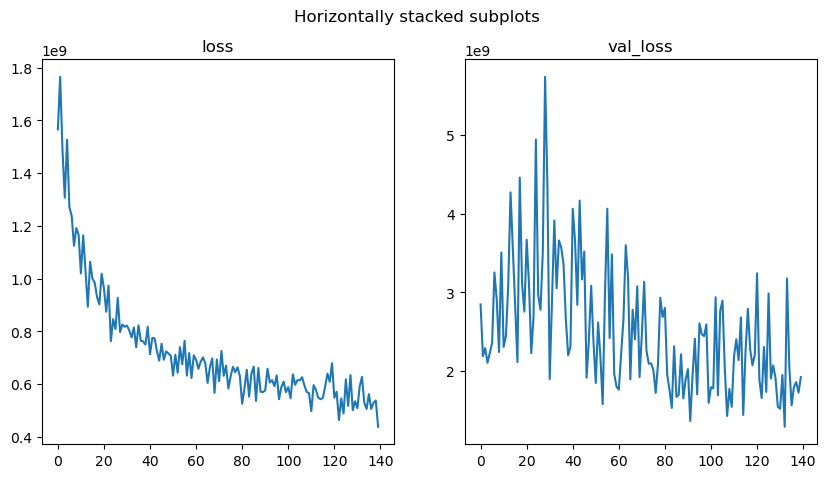

In [159]:
#plt.plot(history.history['loss'][10:])
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
fig.suptitle('Horizontally stacked subplots')
ax1.plot(history.history['loss'][10:])
ax1.set_title("loss")
ax2.plot(history.history['val_loss'][10:])
ax2.set_title("val_loss")
arr_loss = np.array(history.history['loss'])
arr_val = np.array(history.history['val_loss'])
#r2_score(arr_loss, arr_val)


In [135]:
nn.save_weights('/kaggle/working/my_checkpoint')

In [133]:

output = pd.DataFrame({'Id': ids,
                       'SalePrice': pr_nn.squeeze()})
submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission_df['SalePrice'] = pr_nn
submission_df.to_csv('/kaggle/working/submission_nn.csv', index=False)
submission_df.head()

,Id,SalePrice
0,1461,116411.148438
1,1462,159054.921875
2,1463,186048.015625
3,1464,194973.578125
4,1465,183776.984375


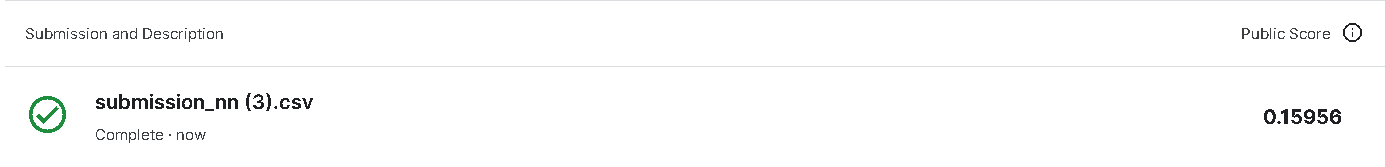
So, this NN worst than TFDF only on 0.01!

# Quick way?

A faster method is to use TFDF. Following approach was taken by [GUSTHEMA and Beta](https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf)

In [2]:
data_tfdf=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_tfdf=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
#train and test split 80%
x_t=data_tfdf[:1168]
x_v=data_tfdf[1168:]

In [4]:
#creating dataset with tf
label = 'SalePrice'
train = tfdf.keras.pd_dataframe_to_tf_dataset(x_t, label=label, task = tfdf.keras.Task.REGRESSION)
valid = tfdf.keras.pd_dataframe_to_tf_dataset(x_v, label=label, task = tfdf.keras.Task.REGRESSION)
test_ds=tfdf.keras.pd_dataframe_to_tf_dataset(test_tfdf, task = tfdf.keras.Task.REGRESSION)

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])
rf.fit(x=train)

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

In [ ]:

evaluation = rf.evaluate(x=valid,return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

In [ ]:

preds = rf.predict(test_ds)

In [ ]:
preds

In [ ]:
gbct = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)
gbct.compile(metrics=["mse"])
gbct.fit(x=train)

In [ ]:
inspector = gbct.make_inspector()
inspector.evaluation()

In [ ]:
evaluation = gbct.evaluate(x=valid,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

In [ ]:

preds_gbct = gbct.predict(test_ds)
preds_gbct

# Submission

In [ ]:
import tensorflow_datasets as tfds
test=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

test.shape

In [ ]:
#test.drop("PoolArea",inplace=True, axis = 1)
#test.drop(['Utilities'],inplace=True, axis = 1)

In [ ]:
test.drop(list(n["columns_name"]),inplace=True, axis = 1)
test.shape

In [ ]:


categorical_with_none = [
    "LotFrontage",
    "MasVnrType",
    "MasVnrArea",
    #"BsmtQual",
    #"BsmtCond",
    "BsmtFinType1",
    "Electrical"
        
]
for col in test.columns:
    mod = test[col].mode()[0]
    test[col] = test[col].fillna(mod)
    

In [ ]:
test.isna().sum().sum()

In [ ]:

test

In [ ]:
categories=test.dtypes.loc[test.dtypes=='object'].index
categories
for i in categories:
    test[i]=le.fit_transform(test[i])
    
test

In [ ]:
ids = test.pop('Id')
#test.drop("Id",inplace=True, axis = 1)
test

In [ ]:
scalert = MinMaxScaler()
test=scalert.fit_transform(test)

In [ ]:
#test=test.to_numpy()
#predict on gbc, coze shows best result
preds = gbc.predict(test)

In [ ]:

preds

In [ ]:
#for submission I choose TFDF with XGB
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds_gbct.squeeze()})
submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission_df['SalePrice'] = preds_gbct
submission_df.to_csv('/kaggle/working/submission.csv', index=False)
submission_df.head()

# Experiments with parameters and models

* GradientBoostingRegressor without tunning
* Data prep: deleting Nans,removing outliers, encoding categorical columns with le.encoder
* Normalazing only numerical columns with MinMaxScaler (without range)
* Data split:0.4
* Score: 0.31382(in best settings, 0.333 in average)

If using LassoCV with PoolArea column after deleted outliers (column turn to zero-column) or PoolArea column without deleting outliers or deleting PoolArea column - score is around 0.37. If deleting Utilities column, which has only one non-zero value, score raises to 0.43.

Also, if delete all suspicious columns - PoolArea, Utilities and BsmtFinType1(has NaNs>2.53%) and using XGB or LassoCV as models, score will raise to around 0.5 or more.

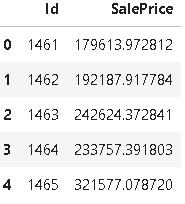

# Conclusion

Preprocessing such small dataset, comparing with real dataset, is not easy job, so for tasks like this, more easily and more precisely - choose TFDF methods from Tensorflow (for now). I plan to try LSTM in next versions. 

***(If you know and want to advise why my models have comparatively low accuracy, I will be very grateful)***